# 251. REINFORCE Algorithm

- Monte-Carlo method를 통해 구한 episodic sample 의 estimated return을 이용하여 policy parameter 𝜃를 update해 나가는 기법

- REINFORCE 갱신 규칙

$$\Delta\theta_t = \alpha\nabla_\theta\log{\pi_\theta}(s, a)G_t$$

- 따라서, Loss function 은
$$-G_t\log{\pi_\theta}(s, a)$$

```
                log_prob = torch.log(pi(state_tensor))
                selected_log_probs = reward_tensor * \
                        torch.gather(log_prob, 1, action_tensor.unsqueeze(1)).squeeze()
                loss = -1 * selected_log_probs.mean()
```

In [1]:
!apt-get install swig

!pip install gym[box2d]

# # install dependencies needed for recording videos
!apt-get install -y xvfb x11-utils > tmp
!pip install -q pyvirtualdisplay==0.2.*

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [2]:
from IPython import display
from IPython.display import HTML
from pyvirtualdisplay import Display
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from base64 import b64encode

In [3]:
import gym
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical;
import time
import os

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


cuda:0


<img src="https://miro.medium.com/max/1400/1*4RncZNj1ij5A5eMJpexhrw.png" width=700/>

### 환경 초기화

In [4]:
#env = gym.make('LunarLander-v2')
env = gym.make('CartPole-v1')

action_space = np.arange(env.action_space.n)
print(action_space)
print(env.observation_space.shape, env.action_space.n)

[0 1]
(4,) 2


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### Policy Network 생성

In [5]:
# A differentiable policy parameterization pi(a|s,theta)
class PolicyNetwork(nn.Module):
    def __init__(self, input_dims, n_actions):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(*input_dims, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        prob = F.softmax(self.fc3(x), dim=-1)
        return prob

#Initialize the parameters theta
pi = PolicyNetwork(input_dims=env.observation_space.shape,
                              n_actions=env.action_space.n).to(device)
pi

PolicyNetwork(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

### hyper-parameters 설정, reward 계산 도우미 함수 생성

In [6]:
#Select step-size parameters 0<alpha<1
alpha = 0.001
#Choose discount rate 0<gamma<1
gamma = 0.99
#Chose max number of episodes N
N = 10_000
# Choose number of episodes to batch together for an update K >= 1
batch_size = 32

optimizer = optim.Adam(pi.parameters(), lr=alpha)

# rendering = True
total_rewards = []

def discount_rewards(rewards):
    Returns = []
    G = 0
    for r in rewards[::-1]:
        G = r + gamma * G
        Returns.append(G)
    # cumsum의 배열 방향을 반대로 한 다음 원래 순서로 되돌립니다.
    Returns = np.array(Returns[::-1], dtype=np.float64)
    # return Returns - Returns.mean()
    return Returns

### main algorithm 작성 / Train
- `CartPole-v0`의 경우 train 약 10 분 소요
- `LunarLander-v2` 의 경우 train 시간 약 1 시간 소요
- 시간 부족할 경우 이미 훈련된  `251_REINFORCE_LunarLander-V2.pth` 를 load 하여 시각화 Test

In [7]:
start_time = time.time()
batch_rewards = []
batch_actions = []
batch_states = []
batch_counter = 1

# While episode n < N do: (training의 안정성 제고)
for episode in range(N):

    s = env.reset()

    # for K batches do:
    states = []
    rewards = []
    actions = []

    done = False
    # Generate an episode s0, a0, r0,...st,at,rt following policy pi(a|s,theta)
    while not done:
        probs = pi(torch.FloatTensor(s).to(device)).detach().cpu().numpy()
        a = np.random.choice(action_space, p=probs)

        s_, r, done, _ = env.step(a)

        states.append(s)
        rewards.append(r)
        actions.append(a)

        s = s_

#         if rendering and (episode > N * 0.98):
#             env.render()

        if done:
            # for each step in the eposide(t), discount reward do:
            # G_t = sum from t=1 to t=T {gamma^t * R_t}
            batch_rewards.extend(discount_rewards(rewards))
            batch_states.extend(states)
            batch_actions.extend(actions)
            batch_counter += 1
            total_rewards.append(sum(rewards))

            # If batch is complete, update network
            if batch_counter == batch_size:
                state_tensor = torch.FloatTensor(batch_states).to(device)
                reward_tensor = torch.FloatTensor(batch_rewards).to(device)
                action_tensor = torch.LongTensor(batch_actions).to(device)

                # Calculate policy loss for all episides in the batch
                # L(theta) = -1/m sum(ln(G_t pi(a|s,theta)))))
                log_prob = torch.log(pi(state_tensor))
                selected_log_probs = reward_tensor * \
                        torch.gather(log_prob, 1, action_tensor.unsqueeze(1)).squeeze()

                loss = -1 * selected_log_probs.mean()

                # Update the policy:
                # theta <- theta + alpha * grad[L(theat)]
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                batch_rewards = []
                batch_actions = []
                batch_states = []
                batch_counter = 1

    if episode % 100 == 0:
        avg_score = np.mean(total_rewards[-100:])
        print(f'episode {episode},  최근 100 episode 평균 reward {avg_score: .2f}')

env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode 0,  최근 100 episode 평균 reward  25.00


<ipython-input-7-afa63ce721d8>:45: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  state_tensor = torch.FloatTensor(batch_states).to(device)


episode 100,  최근 100 episode 평균 reward  20.92
episode 200,  최근 100 episode 평균 reward  23.07
episode 300,  최근 100 episode 평균 reward  24.77
episode 400,  최근 100 episode 평균 reward  28.26
episode 500,  최근 100 episode 평균 reward  28.26
episode 600,  최근 100 episode 평균 reward  30.90
episode 700,  최근 100 episode 평균 reward  34.11
episode 800,  최근 100 episode 평균 reward  42.70
episode 900,  최근 100 episode 평균 reward  47.80
episode 1000,  최근 100 episode 평균 reward  53.88
episode 1100,  최근 100 episode 평균 reward  71.79
episode 1200,  최근 100 episode 평균 reward  78.08
episode 1300,  최근 100 episode 평균 reward  102.29
episode 1400,  최근 100 episode 평균 reward  130.69
episode 1500,  최근 100 episode 평균 reward  170.17
episode 1600,  최근 100 episode 평균 reward  201.37
episode 1700,  최근 100 episode 평균 reward  224.21
episode 1800,  최근 100 episode 평균 reward  245.99
episode 1900,  최근 100 episode 평균 reward  267.58
episode 2000,  최근 100 episode 평균 reward  307.19
episode 2100,  최근 100 episode 평균 reward  332.46
episode 2200,

In [8]:
#torch.save(pi.state_dict(), '251_REINFORCE_LunarLander-V2.pth')

### reward 변화 시각화

duration =  28.597554699579874 minutes


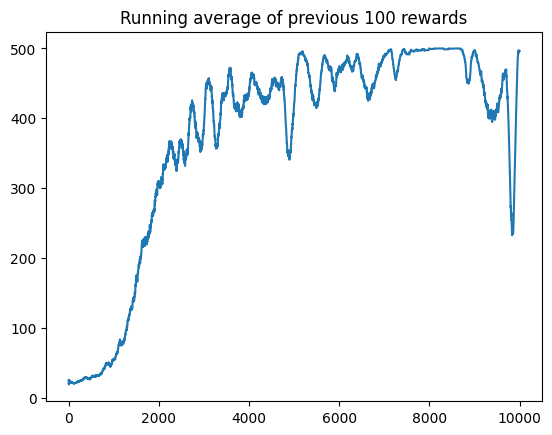

In [9]:
print("duration = ", (time.time() - start_time) / 60, "minutes")

running_avg = np.zeros(len(total_rewards))

for i in range(len(running_avg)):
    running_avg[i] = np.mean(total_rewards[max(0, i-100):(i+1)])

plt.plot(running_avg)
plt.title('Running average of previous 100 rewards')
plt.show()

### 이미 학습되어 저장된 model load

In [10]:
reload = False  # 저장된 모델 사용시  True 로 변경
if reload:
    pi = PolicyNetwork(input_dims=env.observation_space.shape,
                                n_actions=env.action_space.n).to(device)

    pi.load_state_dict(torch.load('251_REINFORCE_LunarLander-V2.pth'))

### Animate it with Video

In [11]:
display = Display(visible=False, size=(1400, 900))
_ = display.start()    # start display

def render_mp4(videopath: str) -> str:
  """
  지정된 경로에 있는 MP4 비디오의 b4 인코딩 버전을 포함하는 문자열을 가져옵니다.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [15]:
file = "train.mp4"

if reload:
    env = gym.make('LunarLander-v2')

video = VideoRecorder(env, file)

# 시각화
state = env.reset()
done = False
while not done:
    video.capture_frame()

    with torch.no_grad():
        probs = pi(torch.FloatTensor(state).to(device)).detach().cpu().numpy()

    a = np.random.choice(action_space, p=probs)

    next_state, reward, done, _ = env.step(a)
    state = next_state

env.close()
video.close()

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [16]:
file = "train.mp4"

html = render_mp4(file)
HTML(html)